In [74]:
import pickle, os
import jieba  
import numpy as np
import pandas as pd
from icecream import ic 
from sklearn.cluster import KMeans 
from collections import defaultdict
from matplotlib import pyplot as plt
from sklearn.preprocessing import Normalizer # 把tfidf归一化为单位向量
from sklearn.naive_bayes import MultinomialNB # 多项式贝叶斯模型
from sklearn.model_selection import train_test_split # 拆分数据集
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer # 统计词频、计算tfidf
from sklearn.metrics import classification_report # 分类报告 评估模型

In [75]:
from sklearn.metrics.pairwise import cosine_similarity # 计算余弦相似度

In [76]:
# 数据加载

In [77]:
with open('F:/BI/第三周/核心班/L3/Assignment/chinese_stopwords.txt', 'r', encoding='utf-8') as file:
    # 直接file.readlines()得到的元素最后是换行符，用切片去掉后面的换行符
    stopwords = [line[:-1] for line in file.readlines()]

In [78]:
stopwords[:10]

['，', '的', '。', '、', '在', '了', '是', '\u3000', '“', '”']

In [79]:
# 数据集加载

df = pd.read_csv('F:/BI/第三周/核心班/L3/Assignment/sqlResult.csv', 
                 encoding='gb18030') # gb18030编码收录的中文字符更全，对中文文档兼容性更好
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89611 entries, 0 to 89610
Data columns (total 7 columns):
id         89611 non-null int64
author     79396 non-null object
source     89609 non-null object
content    87054 non-null object
feature    89611 non-null object
title      89577 non-null object
url        87144 non-null object
dtypes: int64(1), object(6)
memory usage: 4.8+ MB


In [80]:
df.head(2)

,id,author,source,content,feature,title,url
0,89617,NaN,快科技@http://www.kkj.cn/,此外，自本周（6月12日）起，除小米手机6等15款机型外，其余机型已暂停更新发布（含开发版/...,"{""type"":""科技"",""site"":""cnbeta"",""commentNum"":""37""...",小米MIUI 9首批机型曝光：共计15款,http://www.cnbeta.com/articles/tech/623597.htm
1,89616,NaN,快科技@http://www.kkj.cn/,骁龙835作为唯一通过Windows 10桌面平台认证的ARM处理器，高通强调，不会因为只考...,"{""type"":""科技"",""site"":""cnbeta"",""commentNum"":""15""...",骁龙835在Windows 10上的性能表现有望改善,http://www.cnbeta.com/articles/tech/623599.htm


In [81]:
# 数据预处理

In [82]:
df.dropna(subset=['content'], inplace=True)

In [83]:
df.dropna(subset=['source'], inplace=True)

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87052 entries, 0 to 89610
Data columns (total 7 columns):
id         87052 non-null int64
author     76925 non-null object
source     87052 non-null object
content    87052 non-null object
feature    87052 non-null object
title      87052 non-null object
url        87052 non-null object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [85]:
# 使用jieba进行分词处理

In [86]:
def split_text(text):
    text = text.replace(' ', '').replace('\n', '').replace('\r', '')
    text2 = jieba.cut(text.strip())  # strip()可以省略
    # 去掉停用词
    result = ' '.join([w for w in text2 if w not in stopwords])
    return result

In [87]:
temp = df.iloc[0].content
temp

'此外，自本周（6月12日）起，除小米手机6等15款机型外，其余机型已暂停更新发布（含开发版/体验版内测，稳定版暂不受影响），以确保工程师可以集中全部精力进行系统优化工作。有人猜测这也是将精力主要用到MIUI 9的研发之中。\r\nMIUI 8去年5月发布，距今已有一年有余，也是时候更新换代了。\r\n当然，关于MIUI 9的确切信息，我们还是等待官方消息。\r\n'

In [88]:
split_text(temp) # 分词结果

'此外 本周 除 小米 手机 款 机型 外 机型 暂停 更新 发布 含 开发 版 体验版 内测 稳定版 暂不受 影响 确保 工程师 集中 全部 精力 进行 系统优化 工作 有人 猜测 精力 主要 用到 MIUI9 研发 之中 MIUI8 去年 发布 距今已有 一年 有余 更新换代 当然 MIUI9 确切 信息 等待 官方消息'

In [89]:
temp = temp.replace(' ', '').replace('\n', '').replace('\r', '')
temp

'此外，自本周（6月12日）起，除小米手机6等15款机型外，其余机型已暂停更新发布（含开发版/体验版内测，稳定版暂不受影响），以确保工程师可以集中全部精力进行系统优化工作。有人猜测这也是将精力主要用到MIUI9的研发之中。MIUI8去年5月发布，距今已有一年有余，也是时候更新换代了。当然，关于MIUI9的确切信息，我们还是等待官方消息。'

In [90]:
' '.join([w for w in jieba.cut(temp) if w not in stopwords])

'此外 本周 除 小米 手机 款 机型 外 机型 暂停 更新 发布 含 开发 版 体验版 内测 稳定版 暂不受 影响 确保 工程师 集中 全部 精力 进行 系统优化 工作 有人 猜测 精力 主要 用到 MIUI9 研发 之中 MIUI8 去年 发布 距今已有 一年 有余 更新换代 当然 MIUI9 确切 信息 等待 官方消息'

In [91]:
# 分词处理文本

In [92]:
# 假如路径存在，则直接读取，否则进行分词，并保存到本地
if os.path.exists('F:/BI/第三周/核心班/L3/corpus.pkl'):
    with open('F:/BI/第三周/核心班/L3/corpus.pkl', 'rb') as file:
        corpus = pickle.load(file)
else:
    corpus = df['content'].map(split_text)
    # 保存到本地，方便下次读取
    with open('F:/BI/第三周/核心班/L3/corpus.pkl', 'wb') as file:
        pickle.dump(corpus, file)

In [93]:
corpus.shape

(87052,)

In [94]:
type(corpus[0])

str

In [95]:
len(set(corpus[0].split())) # 第一篇文章中有45个不重复的单词

45

In [96]:
# 对新闻进行标记

In [97]:
df['source'].value_counts()

新华社          78661
中国新闻网          523
中国证券报?中证网      510
参考消息网          385
环球网            308
             ...  
成都商报第14版         1
广州日报第A24版        1
扬州晚报             1
科技快报             1
湖北日报第17版         1
Name: source, Length: 971, dtype: int64

In [98]:
label = df['source'].copy()  # 默认深拷贝

In [99]:
label.str.contains('新华').sum()  # 包含'新华'的样本有78855个

78855

In [100]:
target = label.str.contains('新华') * 1  # series.str.contains() 返回布尔索引，用*1转为 0 1

In [101]:
target[:5]

0    0
1    0
2    0
3    1
4    0
Name: source, dtype: int32

In [102]:
target.isnull().sum() # 确认下目标值无缺失值

0

In [103]:
# 计算TF-IDF矩阵

In [104]:
corpus

0        此外 本周 除 小米 手机 款 机型 外 机型 暂停 更新 发布 含 开发 版 体验版 内测...
1        骁龙 835 唯一 Windows10 桌面 平台 认证 ARM 处理器 高通 强调 不会 ...
2        此前 一加 3T 搭载 3400mAh 电池 DashCharge 快充 规格 5V 4A ...
3        这是 18 葡萄牙 中部 佩德罗 冈 地区 拍摄 森林 大火 烧毁 汽车 新华社 记者 张立 云摄
4        原 标题 44 岁 女子 跑 深圳 约会 网友 拒 暴雨 裸身 奔走 … … @ 深圳 交警...
                               ...                        
89606    新华社 照片 多伦多 2017 \ n 体育 冰球 国家 女子 冰球队 海外 选秀 多伦多 ...
89607    新华社 兰州 日电 王衡 徐丹 记者 甘肃省 交通运输 厅 获悉 甘肃 近日 集中 开建 高...
89608    \ n \ n2017 29 法国巴黎 郊外 凡尔赛宫 法国 总统 马克 龙 出席 新闻 发...
89609    \ n \ n2017 25 美国 马萨诸塞州 剑桥市 哈佛大学 毕业生 毕业典礼 欢呼 新...
89610    新华社 德国 杜塞尔多夫 ６ ６ 日电 题 乒乓 女球迷 \ n 新华社 记者 王子江 张寒...
Name: content, Length: 87052, dtype: object

In [105]:
# 进行次品TF计算

In [106]:
from icecream import ic

In [107]:
# 实例化一个统计每个关键词出现的次数的转换器 
countvectorizer = CountVectorizer(encoding='gb18030', 
                                  min_df=0.015) # 某词语的文档频率DF低于该阈值将会被删除

In [108]:
# 通过fit_transform函数将文本中的关键词转换为词频稀疏矩阵
countvector = countvectorizer.fit_transform(corpus) 

In [109]:
ic(type(countvector))
countvector.shape

ic| type(countvector): <class 'scipy.sparse.csr.csr_matrix'>


(87052, 884)

In [110]:
print(countvector[:1])

  (0, 590)	1
  (0, 461)	1
  (0, 271)	2
  (0, 416)	1
  (0, 432)	1
  (0, 669)	1
  (0, 860)	1
  (0, 184)	1
  (0, 822)	1
  (0, 385)	1
  (0, 103)	1
  (0, 667)	1
  (0, 263)	1
  (0, 44)	1
  (0, 174)	1


In [111]:
# 将稀疏矩阵转为数组，稀疏矩阵与数组shape相同，只是展示形式不同
countvector_arr = countvector.toarray()
countvector_arr.shape

(87052, 884)

In [112]:
countvector_arr[0][271] # a[i][j] 表示j词在第i个文本下的词频。即各个词语出现的次数

2

In [113]:
countvector_arr[0].shape # 第一个样本

(884,)

In [114]:
countvector_arr[0].sum() 

16

In [115]:
countvector_arr[0][countvector_arr[0] >= 1] # 与稀疏矩阵的结果相同

array([1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [116]:
# vocabulary_所有文本的关键词和特征索引的映射字典

In [117]:
words_indices = countvectorizer.vocabulary_
len(words_indices)

884

In [118]:
ic(type(words_indices))
list(words_indices.items())[:4]

ic| type(words_indices): <class 'dict'>


[('此外', 590), ('手机', 461), ('发布', 271), ('开发', 416)]

In [119]:
# 字典按value(特征索引号)升序排序
words_indices = sorted(words_indices.items(), key=lambda x: x[1], reverse=False)

In [120]:
words_indices[-5:] # 特征索引号

[('首次', 879), ('首轮', 880), ('首都', 881), ('香港', 882), ('鼓励', 883)]

In [121]:
# get_feature_names()获得所有文本的关键词列表

In [122]:
feature_names = countvectorizer.get_feature_names()

In [123]:
ic(len(feature_names))
ic(type(feature_names))
feature_names[:5]

ic| len(feature_names): 884
ic| type(feature_names): <class 'list'>


['100', '13', '14', '16', '17']

In [124]:
feature_names[-5:]  # 可见关键词默认按特征索引号升序排序

['首次', '首轮', '首都', '香港', '鼓励']

In [125]:
#stop_words_ 停用词

In [126]:
stop_wds = countvectorizer.stop_words_ 

In [127]:
ic(len(stop_wds))
ic(type(stop_wds))
list(stop_wds)[:5] # set对象不能切片提取，所以转为列表

ic| len(stop_wds): 242520
ic| type(stop_wds): <class 'set'>


['依众力', '治台', '醒报', '临中夏', '于高端']

In [128]:
# 将词频矩阵转为TF-IDF矩阵

In [129]:
 # 实例化一个将词频矩阵转为TF-IDF矩阵的实例
tfidftransformer = TfidfTransformer()   

In [130]:
tfidftransformer

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [131]:
# 拟合后返回tfidf稀疏矩阵
tfidf = tfidftransformer.fit_transform(countvector)

In [132]:
ic(type(tfidf))
print(tfidf[0])

ic| type(tfidf): <class 'scipy.sparse.csr.csr_matrix'>


  (0, 860)	0.2674007239601568
  (0, 822)	0.15081444348966608
  (0, 669)	0.2671380200521529
  (0, 667)	0.28309620126453316
  (0, 590)	0.2377411770105167
  (0, 461)	0.28783155518886216
  (0, 432)	0.21737704053822574
  (0, 416)	0.2635573764739399
  (0, 385)	0.18500978673205756
  (0, 271)	0.4315609902828978
  (0, 263)	0.22918780918486897
  (0, 184)	0.2468108139475762
  (0, 174)	0.23459189038564443
  (0, 103)	0.20106899736814415
  (0, 44)	0.2622676107691569


In [133]:
# 所有词汇的逆向文档率idf
ic(type(tfidftransformer.idf_))
ic(tfidftransformer.idf_.shape)
tfidftransformer.idf_[:5]

ic| type(tfidftransformer.idf_): <class 'numpy.ndarray'>
ic| tfidftransformer.idf_.shape: (884,)


array([4.52300041, 3.66596311, 3.71488545, 3.73787497, 3.77016784])

In [134]:
# 对数据集拆分

In [135]:
x_train, x_test, y_train, y_test = train_test_split(tfidf.toarray(), target, test_size=0.2)

In [136]:
# 二维 一维
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((69641, 884), (17411, 884), (69641,), (17411,))

In [137]:
#实例化评估器
estimator = MultinomialNB()
estimator

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [138]:
# 模型训练
estimator.fit(x_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [139]:
# 二分类
estimator.classes_

array([0, 1], dtype=int32)

In [140]:
# 二分类中0的样本数6616, 1的样本数63025
estimator.class_count_

array([ 6545., 63096.])

In [141]:
#  拟合过程中每个(类、特征)遇到的样本数。
ic(estimator.feature_count_.shape)
estimator.feature_count_[0, 0]

ic| estimator.feature_count_.shape: (2, 884)


55.37991187423415

In [142]:
estimator.feature_count_.sum()

304018.0069511251

In [143]:
# 模型评估
y_pred = estimator.predict(x_test)

In [144]:
print(classification_report(y_test, y_pred, labels=[0, 1], target_names=['others', '新华']))

              precision    recall  f1-score   support

      others       0.44      0.65      0.52      1652
          新华       0.96      0.91      0.94     15759

    accuracy                           0.89     17411
   macro avg       0.70      0.78      0.73     17411
weighted avg       0.91      0.89      0.90     17411



In [145]:
# 使用模型预测

In [146]:
prediction = estimator.predict(tfidf.toarray())
prediction

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [147]:
# 构建DataFrame
compare_news_df = pd.DataFrame({"prediction": prediction, 'labels': target.values})

In [148]:
compare_news_df.head(2)

,prediction,labels
0,0,0
1,0,0


In [149]:
# 在实际非新华社的文章中找出预测为新华社风格的文章
copy_news_index = compare_news_df[(compare_news_df['labels'] == 0) & (compare_news_df['prediction'] == 1)]
copy_news_index.head(2)

,prediction,labels
4,1,0
24,1,0


In [150]:
"可能为copy新闻条数:{}".format(len(copy_news_index))

'可能为copy新闻条数:2804'

In [151]:
copy_news_index[:5]

,prediction,labels
4,1,0
24,1,0
28,1,0
30,1,0
32,1,0


In [152]:
# 实际为新华社的新闻的 index
xinhuashe_news_index = compare_news_df[compare_news_df['labels'] == 1].index
xinhuashe_news_index

Int64Index([    3,    17,    25,    27,    39,    51,    65,    95,   102,
              111,
            ...
            87042, 87043, 87044, 87045, 87046, 87047, 87048, 87049, 87050,
            87051],
           dtype='int64', length=78855)

In [154]:
# 实际不是新华社的新闻的 index
no_xinhuashe_news_index = compare_news_df[compare_news_df['labels'] == 0].index
no_xinhuashe_news_index

Int64Index([   0,    1,    2,    4,    5,    6,    7,    8,    9,   10,
            ...
            8544, 8545, 8546, 8547, 8548, 8549, 8550, 8551, 8552, 8553],
           dtype='int64', length=8197)

In [155]:
# 使用K-Means聚类

In [156]:
# 准备数据，x代表弧度
x = np.random.normal(size=1000)
# 升序排序
x.sort() 
y = np.cos(x) 

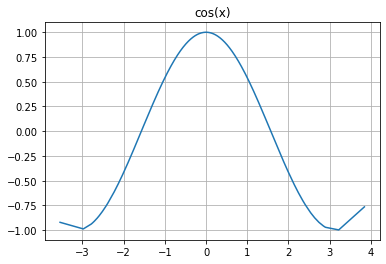

In [158]:
# 绘制余弦曲线
plt.plot(x, y)
plt.grid()
plt.title('cos(x)')
plt.show()

In [159]:
#  L2范式归一化
x = np.array([[4, 1, 2, 2], [1, 3, 9, 3], [5, 7, 5, 1]])
norm_x = Normalizer().fit_transform(x) # 默认是l2范式
print(norm_x)

[[0.8 0.2 0.4 0.4]
 [0.1 0.3 0.9 0.3]
 [0.5 0.7 0.5 0.1]]


In [160]:
# 复现Normalizer的l2范式归一化计算过程 
x = np.array([[4, 1, 2, 2], [1, 3, 9, 3], [5, 7, 5, 1]])
norm_x = []
for i in range(len(x)):
    row = x[i]
    sum_row_sqrt = ((row ** 2).sum()) ** 0.5
    temp = row / sum_row_sqrt
    norm_x.append(temp)
    
print('x:\n', x)
print('norm_x:\n', np.array(norm_x))

x:
 [[4 1 2 2]
 [1 3 9 3]
 [5 7 5 1]]
norm_x:
 [[0.8 0.2 0.4 0.4]
 [0.1 0.3 0.9 0.3]
 [0.5 0.7 0.5 0.1]]


In [161]:
# 对全量文本的TF-IDF进行范式归一化

In [162]:
transfer = Normalizer()
scaled_array = transfer.fit_transform(tfidf.toarray())

In [163]:
ic(type(scaled_array))
scaled_array.shape

ic| type(scaled_array): <class 'numpy.ndarray'>


(87052, 884)

In [164]:
# 对全部聚类

由于数据集较大，先用K-Means进行聚类降维，比如聚类成25堆。后面统计余弦相似度时，抄袭新闻只和自己堆里真实新闻进行计算，有效减少计算量。

In [165]:
estimator2 = KMeans(n_clusters=25)  # 25是人工规定的桶的个数，把87052个样本按照距离分成25类

In [166]:
%%time
estimator2.fit(scaled_array)

Wall time: 5min 16s


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=25, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [167]:
k_labels = estimator2.predict(scaled_array)

In [168]:
ic(k_labels.shape)
k_labels[:5]

ic| k_labels.shape: (87052,)


array([ 3,  3,  3, 10,  3])

In [169]:
# 建立映射关系

In [170]:
# 将预测的k_labels转为Series类型，
k_labels_sr = pd.Series(k_labels)

In [171]:
# id_class = {index: class_ for index, class_ in enumerate(k_labels)}

ic(type(k_labels_sr))

k_labels_sr[:5]

ic| type(k_labels_sr): <class 'pandas.core.series.Series'>


0     3
1     3
2     3
3    10
4     3
dtype: int32

In [172]:
class_id = defaultdict(set)

# 调用Series的实例方法items()，返回(index, value)对的迭代器
for index, value in k_labels_sr.items():
    # 只统计实际是新华社的index
    if index in xinhuashe_news_index:
        class_id[value].add(index)

In [173]:
# 字典的key是0~24的25个类别编号，字典的value是集合
class_id.keys()

dict_keys([10, 3, 15, 14, 2, 22, 24, 6, 23, 21, 5, 7, 16, 17, 19, 20, 11, 4, 8, 13, 18, 0, 1, 9, 12])

In [174]:
ic(type(class_id[12]))
len(class_id[12])

ic| type(class_id[12]): <class 'set'>


1515

In [175]:
# 相似查看

In [176]:
copy_news_index.loc[3352]

prediction    1
labels        0
Name: 3352, dtype: int32

In [177]:
print(tfidf[3352].shape)

(1, 884)


In [178]:
# 计算新闻之间的余弦相似度

In [179]:
# 作为疑似抄袭的新闻，
copy_index = 3352

# 先找到它在聚类后的桶的编号，
label = k_labels_sr[copy_index]

ic(label)

# 再计算它的余弦相似度，49153为聚类后同一个label下的一则真实新华社新闻的index
cosine_similarity(tfidf[copy_index], tfidf[49153]) 

ic| label: 24


array([[0.00458121]])

In [180]:
# 与3352新闻在一个桶里的新华社新闻一共有4460则
news_index_demo = class_id[label]
ic(type(news_index_demo))
len(news_index_demo)

ic| type(news_index_demo): <class 'set'>


1709

In [181]:
# news_index_demo为集合不支持切片，故转为list
list(news_index_demo)[:5]

[16389, 24582, 32774, 65544, 24586]

In [182]:
def find_similar_text(copy_index, top=10):
    # 只在新华社发布的文章中查找
    label = k_labels_sr[copy_index]
    dist_dict = {i: cosine_similarity(tfidf[copy_index], tfidf[i]) for i in class_id[label]}
    # 从大到小排序
    return sorted(dist_dict.items(), key=lambda x: x[1][0], reverse=True)[:top]

In [183]:
similar_list = find_similar_text(copy_index)

In [188]:
# 显示排序TOP10
ic(len(similar_list))
similar_list

ic| len(similar_list): 10


[(3134, array([[0.96848961]])),
 (63509, array([[0.94642972]])),
 (29439, array([[0.94283134]])),
 (3218, array([[0.87621302]])),
 (980, array([[0.87534597]])),
 (29613, array([[0.86935867]])),
 (29886, array([[0.8621539]])),
 (64044, array([[0.85277574]])),
 (29775, array([[0.84875245]])),
 (63972, array([[0.73415204]]))]